使用Info对抗生成网络生成MNIST数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/MNIST/"
NOISE_DIM = 100
Z_DIM = 128
CC_DIM = 1
DC_DIM = 10
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1
BATCH_SIZE = 128
EPOCHS = 100
CONTINUOUS_WEIGHT = 0.5

# 2.模型

In [2]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(Z_DIM + CC_DIM + DC_DIM, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(inplace=True)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 128 * 7 * 7),
            torch.nn.BatchNorm1d(128 * 7 * 7),
            torch.nn.ReLU(inplace=True)
        )

        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 4, 2, 1),
            torch.nn.Tanh()
        )

    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        x = x.view(-1, 128, 7, 7)
        x = self.conv1(x)
        x = self.conv2(x)

        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1),
            torch.nn.LeakyReLU(0.1, True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1, True)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU()
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(128, 1 + CC_DIM + DC_DIM)
        )

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = output.view(-1, 128 * 7 * 7)
        output = self.fc1(output)
        output = self.fc2(output)

        output[:, 0] = torch.nn.functional.sigmoid(output[:, 0].clone())

        output[:, CC_DIM + 1 : CC_DIM + 1 + DC_DIM] = torch.nn.functional.softmax(output[:, CC_DIM + 1 : CC_DIM + 1 + DC_DIM].clone())

        return output


# 3.导入数据

In [3]:
NetG = Generator()
NetD = Discriminator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=0.001, betas=(0.5, 0.999))
trans = tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = tv.datasets.MNIST(root=DATA_PATH,
                               train=True,
                               transform=trans,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

fixed_noise = torch.Tensor(np.zeros((NOISE_DIM, Z_DIM)))
tmp = np.zeros((NOISE_DIM, CC_DIM))
for k in range(10):
    tmp[k * 10:(k + 1) * 10, 0] = np.linspace(-2, 2, 10)
fixed_cc = torch.Tensor(tmp)
tmp = np.zeros((NOISE_DIM, DC_DIM))
for k in range(10):
    tmp[k * 10 : (k + 1) * 10, k] = 1
fixed_dc = torch.Tensor(tmp)

if torch.cuda.is_available():
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    fixed_noise = fixed_noise.cuda()
    fixed_cc = fixed_cc.cuda()
    fixed_dc = fixed_dc.cuda()

fixed_noise_var = torch.autograd.Variable(fixed_noise)
fixed_cc_var    = torch.autograd.Variable(fixed_cc)
fixed_dc_var    = torch.autograd.Variable(fixed_dc)

# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    for i, (images, labels) in enumerate(train_loader):
        mini_batch = images.size(0)

        cc = torch.Tensor(np.random.randn(mini_batch, CC_DIM) * 0.5 + 0.0)

        codes=[]
        code = np.zeros((mini_batch, DC_DIM))
        random_cate = np.random.randint(0, DC_DIM, mini_batch)
        code[range(mini_batch), random_cate] = 1
        codes.append(code)
        codes = np.concatenate(codes,1)
        dc = torch.Tensor(codes)

        noise = torch.randn(mini_batch, Z_DIM)

        if torch.cuda.is_available():
            images = images.cuda()
            cc = cc.cuda()
            dc = dc.cuda()
            noise = noise.cuda()

        images = torch.autograd.Variable(images)
        cc_var = torch.autograd.Variable(cc)
        dc_var = torch.autograd.Variable(dc)
        noise_var = torch.autograd.Variable(noise)

        fake_images = NetG(torch.cat((noise_var, cc_var, dc_var),1))
        d_output_real = NetD(images)
        d_output_fake = NetD(fake_images)

        d_loss_a = -torch.mean(torch.log(d_output_real[:,0]) + torch.log(1 - d_output_fake[:,0]))

        # Mutual Information Loss
        output_cc = d_output_fake[:, 1:1+CC_DIM]
        output_dc = d_output_fake[:, 1+CC_DIM:]
        d_loss_cc = torch.mean((((output_cc - 0.0) / 0.5) ** 2))
        d_loss_dc = -(torch.mean(torch.sum(dc_var * output_dc, 1)) + torch.mean(torch.sum(dc_var * dc_var, 1)))

        d_loss = d_loss_a + CONTINUOUS_WEIGHT * d_loss_cc + 1.0 * d_loss_dc

        # Optimization
        NetD.zero_grad()
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        # ===================== Train G =====================#
        # Fake -> Real
        g_loss_a = -torch.mean(torch.log(d_output_fake[:,0]))

        g_loss = g_loss_a + CONTINUOUS_WEIGHT * d_loss_cc + 1.0 * d_loss_dc

        # Optimization
        NetG.zero_grad()
        g_loss.backward()
        optimizerG.step()

        showbar.show(epoch, d_loss.item(), g_loss.item())

Epoch:1 / 100 [                                                                                                                     ] 3 / 469 ,D Loss:0.436;G Loss:-0.144,remain=0:06:02

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:1 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-0.483;G Loss:-0.824,total=0:00:350
Epoch:2 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-0.692;G Loss:-1.022,total=0:00:290
Epoch:3 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-0.715;G Loss:-1.140,total=0:00:290
Epoch:4 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-0.784;G Loss:-1.076,total=0:00:290
Epoch:5 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-0.774;G Loss:-1.105,total=0:00:290
Epoch:6 / 100 [*********************************************

Epoch:43 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.071;G Loss:-0.460,total=0:00:39007:3351
Epoch:44 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.016;G Loss:-0.466,total=0:00:40046:0151
Epoch:45 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.198;G Loss:-0.129,total=0:00:39018:4309
Epoch:46 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.179;G Loss:-0.401,total=0:00:40052:5249
Epoch:47 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.165;G Loss:-0.468,total=0:00:40027:0306
Epoch:48 / 100 [****

Epoch:84 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.310;G Loss:0.178,total=0:00:290600:3691
Epoch:85 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.477;G Loss:0.579,total=0:00:2906:14:358
Epoch:86 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.377;G Loss:0.119,total=0:00:2903:28:382
Epoch:87 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.351;G Loss:0.180,total=0:00:290408:3724
Epoch:88 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:-1.158;G Loss:-0.010,total=0:00:28021:4064
Epoch:89 / 100 [****

# 5.生成

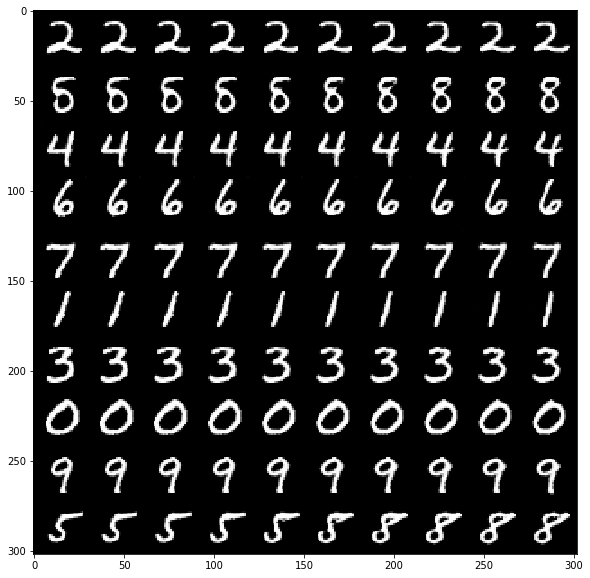

In [6]:
fake_u=NetG(torch.cat((fixed_noise_var, fixed_cc_var, fixed_dc_var), 1))
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))